# First Assignment 
* Each exercise is distinquished from the other using a h2 header.
* All datasets are downloaded via URL, except one for which instructions will be offered.

>Themelina Kouzoumpasi
>p3170076

* All libraries used in this assignment are imported below.

In [1]:
# libraries' imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# If max_cols is exceeded, switch to truncate view
pd.set_option('display.max_columns', None)

# to open a graph on same slide
%matplotlib inline


## Exercise 1
* The dataset containing all information about all candidates is located at https://www.fec.gov/files/bulk-downloads/2016/cn16.zip and its header file at https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv.

* The dataset containing all information about all committees is located at https://www.fec.gov/files/bulk-downloads/2016/cm16.zip and its header file at http://www.fec.gov/files//bulk-downloads/data_dictionaries/cm_header_file.csv

* The dataset containing all information about all contributions from committees to candidates is located at https://www.fec.gov/files/bulk-downloads/2016/pas216.zip and its header file at http://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv

* Regarding the candidates dataset, firstly the header file is read.
* The DataFrame `headers_can` is then converted into a list so as to be used in reading the actual data.

In [2]:
headers_can = pd.read_csv('https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cn_header_file.csv')

headers_can = headers_can.columns.tolist()

* Then the actual data is read. 

In [3]:
candidates = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cn16.zip',
                          sep="|",
                          index_col=False,
                          names=headers_can)

* Same goes for the committees dataset.

In [4]:
headers_com = pd.read_csv('http://www.fec.gov/files//bulk-downloads/data_dictionaries/cm_header_file.csv')

headers_com = headers_com.columns.tolist()

* Then the actual data is read.

In [5]:
committees = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cm16.zip',
                          sep="|",
                          index_col=False,
                          names=headers_com)

* Same goes for the contributions from committees to candidates dataset.
* In this dataset, all columns but one are defined as strings, while `TRANSACTION_AMT` column is defined as float.

In [6]:
headers_contr = pd.read_csv('http://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv')

headers_contr = headers_contr.columns.tolist()

dtype_contr = {h: np.str for h in headers_contr}
dtype_contr['TRANSACTION_AMT'] = np.float

* Then the actual data is read.

In [7]:
contributions = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/pas216.zip',
                          sep="|",
                          index_col=False,
                          names=headers_contr,
                          parse_dates=['TRANSACTION_DT'],
                          dtype=dtype_contr)

* We are interested only for the contributions made by PACs
* So, an inner join has to be executed in order to connect all contributions' committees to their type.

In [8]:
contributions_TP = pd.merge(contributions,
                             committees[['CMTE_TP','CMTE_ID', 'CMTE_NM']],
                             on='CMTE_ID',
                             how='inner')
contributions_TP.columns

Index(['CMTE_ID', 'AMNDT_IND', 'RPT_TP', 'TRANSACTION_PGI', 'IMAGE_NUM',
       'TRANSACTION_TP', 'ENTITY_TP', 'NAME', 'CITY', 'STATE', 'ZIP_CODE',
       'EMPLOYER', 'OCCUPATION', 'TRANSACTION_DT', 'TRANSACTION_AMT',
       'OTHER_ID', 'CAND_ID', 'TRAN_ID', 'FILE_NUM', 'MEMO_CD', 'MEMO_TEXT',
       'SUB_ID', 'CMTE_TP', 'CMTE_NM'],
      dtype='object')

* In addition, we are interested only for Donald Trump and Hillary Clinton.
* So, another inner join has to executed in order to find all contributions connected to the candidate's name they support, and afterwards to find of these contributions only those made for D.Trump or H.Clinton.

In [9]:
contr_TP_can = pd.merge(contributions_TP,
                       candidates[['CAND_ID', 'CAND_NAME']],
                       on='CAND_ID',
                       how='inner')
contr_TP_can.columns

Index(['CMTE_ID', 'AMNDT_IND', 'RPT_TP', 'TRANSACTION_PGI', 'IMAGE_NUM',
       'TRANSACTION_TP', 'ENTITY_TP', 'NAME', 'CITY', 'STATE', 'ZIP_CODE',
       'EMPLOYER', 'OCCUPATION', 'TRANSACTION_DT', 'TRANSACTION_AMT',
       'OTHER_ID', 'CAND_ID', 'TRAN_ID', 'FILE_NUM', 'MEMO_CD', 'MEMO_TEXT',
       'SUB_ID', 'CMTE_TP', 'CMTE_NM', 'CAND_NAME'],
      dtype='object')

* To isolate the contributions for D.Trump and H.Clinton, we need to check the entries of both of them in the `candidates` DataFrame, so as to be able to find their IDs, and therefore the PACs that support them. 

In [10]:
candidates['CAND_NAME'].unique()

array(['COX, JOHN R.', 'ROBY, MARTHA', 'JOHN, ROBERT E JR', ...,
       'CANTWELL, MARIA', 'FEINGOLD, RUSSELL DANA', 'NEUMANN, MARK W'],
      dtype=object)

* Having found the two names, `CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE` and `TRUMP, DONALD J. / MICHAEL R. PENCE `, all contributions made specifically for D.Trump or H.Clinton can be found

In [11]:
trump = 'TRUMP, DONALD J. / MICHAEL R. PENCE '
hillary = 'CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE'

contr_TP_2 = contr_TP_can.loc[contr_TP_can['CAND_NAME'].isin([hillary, trump])]

* Based on the `"Committee type code descriptions" Table`, located at https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/, all PACs have committee type of the subset {N,O,Q,V,W}. 
* Therefore, getting all entries having one of these values will assure us that the `contr_PAC_2` DataFrame will have only contributions made by PACs.

In [12]:
contr_PAC_2 = contr_TP_2[contr_TP_2['CMTE_TP'].isin(['N','O','Q','V','W'])]

* As seen with the output of the command below, `contr_TP_2` DataFrame contains both contributions and refunds. 

In [13]:
(contr_PAC_2['TRANSACTION_AMT'] > 0).value_counts()

True     12885
False      189
Name: TRANSACTION_AMT, dtype: int64

* So, in order to isolate the contributions, only the poisitive values of `TRANSACTION_AMT` are kept in the DataFrame

In [14]:
contr_PAC_2 = contr_PAC_2[contr_PAC_2['TRANSACTION_AMT']>0]

* Now we can find the **Top 5 PACs that supported each of the two presidential candidates**.

In [15]:
contr_PAC_2.groupby(['CMTE_NM','CMTE_ID'])\
           .sum('TRANSACTION_AMT')\
           .sort_values(by='TRANSACTION_AMT', ascending=False)\
           .head(5)

,,TRANSACTION_AMT
CMTE_NM,CMTE_ID,
PRIORITIES USA ACTION,C00495861,132535920.0
FUTURE45,C00574533,24219101.0
GREAT AMERICA PAC,C00608489,23885769.0
REBUILDING AMERICA NOW,C00618876,21280098.0
OUR PRINCIPLES PAC,C00603621,16353117.0


* The **Top 5 PACs that supported H.Clinton** are shown below.

In [16]:
contr_PAC_2[contr_PAC_2['CAND_NAME']== hillary]\
           .groupby(['CMTE_NM','CMTE_ID'])\
           .sum('TRANSACTION_AMT')\
           .sort_values(by='TRANSACTION_AMT', ascending=False)\
           .head(5)

,,TRANSACTION_AMT
CMTE_NM,CMTE_ID,
FUTURE45,C00574533,24195670.0
REBUILDING AMERICA NOW,C00618876,17184458.0
NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICAL VICTORY FUND,C00053553,7448440.0
PRIORITIES USA ACTION,C00495861,6473727.0
LCV VICTORY FUND,C00486845,6283002.0


* The **Top 5 PACs that supported D.Trump** are shown below.

In [17]:
contr_PAC_2[contr_PAC_2['CAND_NAME']== trump]\
           .groupby(['CMTE_NM','CMTE_ID'])\
           .sum('TRANSACTION_AMT')\
           .sort_values(by='TRANSACTION_AMT', ascending=False)\
           .head(5)

,,TRANSACTION_AMT
CMTE_NM,CMTE_ID,
PRIORITIES USA ACTION,C00495861,126062193.0
GREAT AMERICA PAC,C00608489,23881256.0
OUR PRINCIPLES PAC,C00603621,16353117.0
NEXTGEN CALIFORNIA ACTION COMMITTEE,C00615815,13240861.0
LIFT LEADING ILLINOIS FOR TOMORROW,C00625525,9922027.0


## Exercise 2
* The dataset containing all information about the individuals' contributions is located at https://www.fec.gov/files/bulk-downloads/2016/indiv16.zip and its header at https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv
* Due to the file's size, the data is converted into a DataFrame after it's been downloaded and unzipped on the same path of the assignment's file.

* Regarding the contributions by individuals dataset, firstly the header file is read.
* The DataFrame `headers_indiv` is then converted into a list so as to be used in reading the actual data.

In [18]:
headers_indiv = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv')

headers_indiv = headers_indiv.columns.tolist()
headers_indiv

['CMTE_ID',
 'AMNDT_IND',
 'RPT_TP',
 'TRANSACTION_PGI',
 'IMAGE_NUM',
 'TRANSACTION_TP',
 'ENTITY_TP',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'EMPLOYER',
 'OCCUPATION',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'TRAN_ID',
 'FILE_NUM',
 'MEMO_CD',
 'MEMO_TEXT',
 'SUB_ID']

* As this dataset is very big, columns `AMNDT_IND`_(index:1)_, `RPT_TP`_(index:2)_, `TRANSACTION_PGI`_(index:3)_, `IMAGE_NUM`_(index:4)_, `FILE_NUM`_(index:17)_, `MEMO_CD`_(index:18)_, `MEMO_TEXT`_(index:19)_ are not included in the DataFrame. This step is to eliminate any possibility of a `MemoryError` due to lack of memory because of the size of the file.
* In order to do that, the `headers_indiv` list should also not contain these columns.

In [19]:
# list of columns to be removed from headers_indiv
remove_col = ['AMNDT_IND', 'RPT_TP', 'TRANSACTION_PGI', 'IMAGE_NUM', 'FILE_NUM', 'MEMO_CD', 'MEMO_TEXT']

for c in remove_col:
    headers_indiv.remove(c)
    
headers_indiv

['CMTE_ID',
 'TRANSACTION_TP',
 'ENTITY_TP',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'EMPLOYER',
 'OCCUPATION',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'TRAN_ID',
 'SUB_ID']

* All columns but one are defined as strings, while `TRANSACTION_AMT` column is defined as float

In [20]:
dtype_indiv = {h: np.str for h in headers_indiv}
dtype_indiv['TRANSACTION_AMT'] = np.float

* The actual data is read through a local path. Specifically, on the same folder of the assignment's file in folder `indiv16`. 
* Data is divided into two parts to make the process more efficient.
* Only columns not ignored in the `headers_indiv` list are used.

In [22]:
# Part One of the dataset
individuals_1 = pd.read_csv('indiv16/itcont.txt',
                          sep="|",
                          index_col=False,
                          nrows=10000000,
                          usecols=[0,5,6,7,8,9,10,11,12,13,14,15,16,20],
                          names=headers_indiv,
                          parse_dates=['TRANSACTION_DT'],
                          dtype=dtype_indiv)

# Part Two of the dataset
individuals_2 = pd.read_csv('indiv16/itcont.txt',
                          sep="|",
                          index_col=False,
                          skiprows=10000000,
                          usecols=[0,5,6,7,8,9,10,11,12,13,14,15,16,20],
                          names=headers_indiv,
                          parse_dates=['TRANSACTION_DT'],
                          dtype=dtype_indiv)

* As shown below, this dataset contains both contributions and refunds, but we are only interested in contributions _(testing only one of the two parts of the dataset is enough to know that there are refunds across the dataset)._

In [23]:
(individuals_1['TRANSACTION_AMT'] > 0).value_counts()

True     9824580
False     175420
Name: TRANSACTION_AMT, dtype: int64

* So, to remove all refunds, we keep only the positive values of `TRANSACTION_AMT`.

In [25]:
individuals_1 = individuals_1[individuals_1['TRANSACTION_AMT'] > 0]
individuals_2 = individuals_2[individuals_2['TRANSACTION_AMT'] > 0]
print(individuals_1.shape,'\n',individuals_2.shape)

(9824580, 14) 
 (10260230, 14)


* We are interested only for the two presidential candidates.
* First, we need to connect the committees to the candidate's name they support.

In [26]:
committees_can = pd.merge(committees,
                          candidates[['CAND_ID','CAND_NAME']],
                          on='CAND_ID',
                          how='inner')

* Then, to find all contributions made to committees that directly support D.Trump or H.Clinton, an inner join between `individuals` _(individuals_1 + individuals_2)_ and `committees` DataFrames is needed. 
* `committees` DataFrame was defined in Exercise 1

In [28]:
# Part One of the dataset
indiv_1_can = pd.merge(individuals_1,
                       committees_can[['CMTE_ID','CAND_ID', 'CAND_NAME']],
                       on='CMTE_ID',
                       how='inner')

# Part Two of the dataset
indiv_2_can = pd.merge(individuals_2,
                       committees_can[['CMTE_ID','CAND_ID', 'CAND_NAME']],
                       on='CMTE_ID',
                       how='inner')

* Finally, we isolate the contributions that directly supported D.Trump or H.Clinton.

In [30]:
indiv_1_2 = indiv_1_can[indiv_1_can['CAND_NAME'].isin([trump, hillary])].copy()
indiv_2_2 = indiv_2_can[indiv_2_can['CAND_NAME'].isin([trump, hillary])].copy()
print(indiv_1_2.shape,'\n',indiv_2_2.shape)

(1438717, 16) 
 (1223324, 16)


* We are interested only in finding contributions made by individuals, **specifically persons**, so using the `ENTITY_TP` column we isolate those contributions.
* This column is only valid for electronic filings, so before we use it, we need to check if there is any entry that doesn't have a valid value in this column.
* `axes[0]` returns all rows of the DataFrame caller, and `len(axes[0])` returns the number of rows of the DataFrame caller

In [31]:
a = indiv_1_2['ENTITY_TP'].value_counts()
b = indiv_2_2['ENTITY_TP'].value_counts()
print(a,'\n',
      'entries with non-Null ENTITY_TP = number of entries ->',len(indiv_1_2.axes[0])==a.sum(),'\n\n',
      b,'\n',
      'entries with non-Null ENTITY_TP = number of entries ->',len(indiv_2_2.axes[0])==b.sum())

IND    1438609
CAN         98
ORG          9
PAC          1
Name: ENTITY_TP, dtype: int64 
 entries with non-Null ENTITY_TP = number of entries -> True 

 IND    1223173
CAN         99
ORG         47
COM          4
PAC          1
Name: ENTITY_TP, dtype: int64 
 entries with non-Null ENTITY_TP = number of entries -> True


* As proved above, there are no invalid entries in column `ENTITY_TP`, so we can isolate all contributions made by persons.

In [33]:
indiv_1_2 = indiv_1_2[indiv_1_2['ENTITY_TP'].isin(['IND','CAN'])]
indiv_2_2 = indiv_2_2[indiv_2_2['ENTITY_TP'].isin(['IND','CAN'])]

* Now that `indiv_1_2` and `indiv_2_2` have all contributions made for D.Trump or H.Clinton and the sum of their sizes is much smaller than the initial size, we can combine the two DataFrames into one.
* This process is done by the command `append`. The parameter `ignore_index` is set to `True` so as to maintain the index of `indiv_1_2` DataFrame continuous.

In [34]:
indiv_2 = indiv_1_2.append(indiv_2_2, ignore_index=True)
print(indiv_2.shape)

(2661979, 16)


* DataFrame `indiv_2` has all contributions made by individuals for committees that are **directly** linked to one of the two candidates.

* An individual can support a candidate **indirectly** by donating an amount of money to an entity (committee, PAC etc), which connects to the candidate via another entity. 
            


* `indiv_1_indirect` DataFrame contains all contributions of the 1st part of the dataset, where the entities that these contributions were donated at were not connected directly to a candidate. Same goes for the `indiv_2_indirect` for the 2nd part of the dataset.
* Column `SUB_ID` is a unique value that identifies each of entries of the dataset.
  
_As a verification of the output, the 1st initial dataset's part (`individuals_1`) contains 9824580 entries, and 3089146 of them were connected to a candidate (`indiv_1_can`). That means that the rest of them,9824580-3089146=6735434 in number,are not connected directly to a candidate. Same goes for the 2nd dataset's part._

In [36]:
#indiv_1_indirect = individuals_1[~individuals_1['SUB_ID'].isin(indiv_1_can['SUB_ID'])]
indiv_2_indirect = individuals_2[~individuals_2['SUB_ID'].isin(indiv_2_can['SUB_ID'])]
print(indiv_1_indirect.shape,'\n',indiv_2_indirect.shape)

(6735434, 14) 
 (6289997, 14)


* Since we are looking for indirect contributions, we are interested in earmarked controbutions, that is contributions with `TRANSACTION_TP` with codes `15C`, `15I`, `15T`, `24I`, `24T`, based on the [Transaction Type Code Desciption Table](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/)

In [38]:
#indiv_1_indirect = indiv_1_indirect[indiv_1_indirect['TRANSACTION_TP'].isin(['15C','15I','15T','24I','24T'])].copy()
indiv_2_indirect = indiv_2_indirect[indiv_2_indirect['TRANSACTION_TP'].isin(['15C','15I','15T','24I','24T'])].copy()
print(indiv_1_indirect.shape,'\n',indiv_2_indirect.shape)

(2308227, 14) 
 (1724551, 14)


* Now that `indiv_1_indirect` and `indiv_2_indirect` DataFrames have manageable sizes, we can combine the two into one DataFrame.

In [39]:
indiv_indirect = indiv_1_indirect.append(indiv_2_indirect, ignore_index=True)
print(indiv_indirect.shape)

(4032778, 14)


* Since `indiv_indirect` DataFrame contains all **indirect** contributions by individuals, these contributions were sent from the entities that initially received them to another entity _(intermediary committee)_.
* That means that we need the data found at https://www.fec.gov/files/bulk-downloads/2016/oth16.zip with its header https://www.fec.gov/files/bulk-downloads/data_dictionaries/oth_header_file.csv, which contains all committee-to-committee transactions.
* [fec.gov](https://www.fec.gov/campaign-finance-data/contributions-committees-candidates-file-description/) refers that contributions from committees to candidates dataset (seen in Exercise 1,`contributions`) is a subset of this dataset (`ctc`), so it isn't neccessary to check both datasets.

* Firstly the header file is read.
* The DataFrame `headers_ctc` is then converted into a list so as to be used in reading the actual data.

In [40]:
headers_ctc = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/oth_header_file.csv')

headers_ctc = headers_ctc.columns.tolist()
headers_ctc

['CMTE_ID',
 'AMNDT_IND',
 'RPT_TP',
 'TRANSACTION_PGI',
 'IMAGE_NUM',
 'TRANSACTION_TP',
 'ENTITY_TP',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'EMPLOYER',
 'OCCUPATION',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'TRAN_ID',
 'FILE_NUM',
 'MEMO_CD',
 'MEMO_TEXT',
 'SUB_ID']

* As this dataset will be connected to `indiv_indirect` DataFrame, which has a big size, columns `AMNDT_IND`_(index:1)_, `RPT_TP`_(index:2)_, `TRANSACTION_PGI`_(index:3)_, `IMAGE_NUM`_(index:4)_, `ENTITY_TP`_(index:6)_, `CITY`_(index:8)_, `ZIP_CODE`_index(10)_, `EMPLOYER`_(index:11)_, `OCCUPATION`_(index:12)_, `MEMO_CD`_(index:18)_, `MEMO_TEXT`_(index:19)_ are not included in the DataFrame. This step is to eliminate any possibility of a `MemoryError` due to lack of memory because of the size of the file.
* In order to do that, the `headers_ctc` list should also not contain these columns.

In [41]:
# list of columns to be removed from headers_ctc
remove_col = ['AMNDT_IND', 'RPT_TP', 'ENTITY_TP','TRANSACTION_PGI', 'IMAGE_NUM', 'CITY', 'ZIP_CODE', 'EMPLOYER', 'OCCUPATION','MEMO_CD', 'MEMO_TEXT']

for c in remove_col:
    headers_ctc.remove(c)
    
headers_ctc

['CMTE_ID',
 'TRANSACTION_TP',
 'NAME',
 'STATE',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'OTHER_ID',
 'TRAN_ID',
 'FILE_NUM',
 'SUB_ID']

* All columns but one are defined as strings, while `TRANSACTION_AMT` column is defined as float

In [42]:
dtype_ctc = {h: np.str for h in headers_ctc}
dtype_ctc['TRANSACTION_AMT'] = np.float

* Then the actual data is read

In [43]:
ctc = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oth16.zip',
                   sep="|",
                   index_col=False,
                   usecols=[0,5,7,9,13,14,15,16,17,20],
                   names=headers_ctc,
                   parse_dates = ['TRANSACTION_DT'],
                   dtype=dtype_ctc)

* The receivers of these contributions should be directly linked to at least one candidate, so an inner join of the `candidates` and the `ctc` DataFrames should be executed.

In [44]:
ctc_can = pd.merge(ctc,
                   committees_can[['CMTE_ID','CAND_ID','CAND_NAME']],
                   on='CMTE_ID',
                   how='inner')
print(ctc_can.shape)

(1084216, 12)


* We are interested only for contributions for the two candidates, D.Trump and H.Clinton.

In [45]:
ctc_2 = ctc_can[ctc_can['CAND_NAME'].isin([hillary,trump])]
print(ctc_2.shape)

(956784, 12)


* We are interested only for earmarked contributions, that is contributions with TRANSACTION_TP with codes `18K`,`18J`,`15J`,`24Z`,`24K`,`24G` based on the `Transaction type code desciption` Table located at https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/

In [46]:
ctc_2 = ctc_2[ctc_2['TRANSACTION_TP'].isin(['18K','18J','15J','24Z','24K','24G'])]
ctc_2.shape

(956532, 12)

* We are looking for only for positive contributions.

In [47]:
(ctc_2['TRANSACTION_AMT'] > 0).value_counts()

True     949369
False      7163
Name: TRANSACTION_AMT, dtype: int64

* All the committees that received an amount of money from individuals and that they aren't directly linked to at least one of the two candidates, having id `CMTE_ID` in DataFrame `indiv_indirect`, send this amount of money to a committee that is directly linked 

In [48]:
ctc_2 = ctc_2[~(ctc_2['OTHER_ID'].isnull())]
ctc_2.shape

(843, 12)

* Finally, all indirect contributions made by people for each of the two candidates are found.

In [49]:
indiv_indirect_2 = pd.merge(ctc_2[['OTHER_ID','CAND_NAME','TRANSACTION_AMT']],
                            indiv_indirect[['CMTE_ID', 'TRANSACTION_TP', 'ENTITY_TP', 'NAME', 'STATE', 'ZIP_CODE','EMPLOYER', 'OCCUPATION', 'TRANSACTION_DT', 'TRANSACTION_AMT']],
                            left_on=['OTHER_ID','TRANSACTION_AMT'],
                            right_on=['CMTE_ID','TRANSACTION_AMT'],
                            how='inner')

* Having collected all direct and indirect contributions by people for D.Trump and H.Clinton, we combine the two DataFrames into one.

In [50]:
indiv_all = indiv_2[['CMTE_ID','TRANSACTION_TP','NAME','STATE','ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','CAND_NAME']].append(indiv_indirect_2[['CMTE_ID','TRANSACTION_TP','NAME','STATE','ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','CAND_NAME']],ignore_index=True)
indiv_all.shape

(2663103, 11)

* The **Top 10 individual donors for each of the two candidates** are displayed below.

In [51]:
indiv_all.groupby(['NAME','STATE'])\
         .sum('TRANSACTION_AMT')\
         .sort_values(by='TRANSACTION_AMT', ascending=False)\
         .head(10)

,,TRANSACTION_AMT
NAME,STATE,
"TRUMP, DONALD J",NY,10033637.0
"TRUMP, DONALD J.",NY,6532038.0
"TRUMP, DONALD J J.",NY,2067482.0
"CLINTON, HILLARY RODHAM",NY,1450306.0
"BOCH, ERNIE",MA,171172.0
"TREIBEL, RANDY",WA,52352.0
"HOME DEPOT INC, PAC",DC,40000.0
NATIONAL BEER WHOLESALERS ASSOCIATION PAC,VA,40000.0
"HAMLIN, TRISH",NY,38400.0


* The **Top 10 individual donors for H.Clinton** are displayed below.

In [52]:
indiv_all[indiv_all['CAND_NAME']==hillary].groupby(['NAME','STATE'])\
         .sum('TRANSACTION_AMT').sort_values(by='TRANSACTION_AMT', ascending=False)\
         .head(10)

,,TRANSACTION_AMT
NAME,STATE,
"CLINTON, HILLARY RODHAM",NY,1450306.0
NATIONAL BEER WHOLESALERS ASSOCIATION PAC,VA,40000.0
"HOME DEPOT INC, PAC",DC,40000.0
"RUNYAN, R. BRADLEY",DC,35100.0
"BURNS, URSULA",CT,32400.0
"FRIEDMAN, JANELLE",TX,32400.0
"ELLING, MARTIN",NY,32399.0
BADGER PAC,DC,30000.0
"BERLEKAMP, ELWYN",CA,24500.0


* The **Top 10 individual donors for H.Clinton** are displayed below.

In [53]:
indiv_all[indiv_all['CAND_NAME']==trump].groupby(['NAME','STATE'])\
         .sum('TRANSACTION_AMT').sort_values(by='TRANSACTION_AMT', ascending=False)\
         .head(10)

,,TRANSACTION_AMT
NAME,STATE,
"TRUMP, DONALD J",NY,10033637.0
"TRUMP, DONALD J.",NY,6532038.0
"TRUMP, DONALD J J.",NY,2067482.0
"BOCH, ERNIE",MA,171172.0
"TREIBEL, RANDY",WA,52352.0
"HAMLIN, TRISH",NY,38400.0
"HYDE, ROBERT",CT,34085.0
"GIGANTE, PETER",WA,26300.0
"BARRETT, NOEL",MS,24300.0


### Exercise 3
* The dataset containing all information about the operating expenditures is located at https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip and its header at https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv

* Firstly the header file is read.
* The DataFrame `headers_opex` is then converted into a list so as to be used in reading the actual data.

In [54]:
headers_opex = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv')

headers_opex = headers_opex.columns.tolist()
headers_opex

['CMTE_ID',
 'AMNDT_IND',
 'RPT_YR',
 'RPT_TP',
 'IMAGE_NUM',
 'LINE_NUM',
 'FORM_TP_CD',
 'SCHED_TP_CD',
 'NAME',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'TRANSACTION_DT',
 'TRANSACTION_AMT',
 'TRANSACTION_PGI',
 'PURPOSE',
 'CATEGORY',
 'CATEGORY_DESC',
 'MEMO_CD',
 'MEMO_TEXT',
 'ENTITY_TP',
 'SUB_ID',
 'FILE_NUM',
 'TRAN_ID',
 'BACK_REF_TRAN_ID']

* All columns but one are defined as strings, while `TRANSACTION_AMT` column is defined as float

In [55]:
dtype_opex = {h: np.str for h in headers_opex}
dtype_opex['TRANSACTION_AMT'] = np.float


* Then the actual data is read

In [56]:
opex = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip',
                   sep="|",
                   index_col=False,
                   names=headers_opex,
                   parse_dates = ['TRANSACTION_DT'],
                   dtype=dtype_opex)

* Expenditures with `TRANSACTION_AMT` having negative value are considered to be voided, so they will not be included in the total amount of expenditures.

In [57]:
opex = opex[opex['TRANSACTION_AMT']>0]

* The chronological evolution will be by month. So, in the `TRANSACTION_DT` column, there's no need to have day values.
* As we are interested only for 2015-2016 dates, we should check whether all values are valid or not.

In [58]:
((opex['TRANSACTION_DT']>'12/31/2016') | (opex['TRANSACTION_DT']<'01/01/2015')).value_counts()

False    1729612
True           6
Name: TRANSACTION_DT, dtype: int64

* There are 6 invalid values.
* To remove all invalid values, all values should be converted into datetime type, as it is easier to spot these values this way.
* [to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) is used, with `errors=coerce` capturing all invalid for Pandas values and replacing them with a `NaT` value.

In [59]:
opex.loc[:,'TRANSACTION_DT'] = pd.to_datetime(opex['TRANSACTION_DT'], errors='coerce')

* As said before, only dates between 2015-2016 are of our interest, so any dates beyond these should not be included.

In [60]:
opex = opex[(opex['TRANSACTION_DT']>='2015-01-01') & (opex['TRANSACTION_DT']<='2016-12-31')]

* To find all operating expenditures made by the two campaigns, we need to know the campaigns' names and ids.
* `committees_can` DataFrame was defined in Exercise 2, and it contains all committees directly linked to a candidate.
* `CMTE_TP` column defines the type of the committee, and by selecting all entries with "P" type, we define that we only want the campaign committees for the two presindential candidates (based on the [Committee Type Code Description Table](https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/))

In [61]:
committees_can[(committees_can['CAND_NAME'].isin([trump,hillary])) & (committees_can['CMTE_TP']=='P')]

,CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID,CAND_NAME
3925,C00575795,HILLARY FOR AMERICA,"VILLARREAL, JOSE H.",P.O. BOX 5256,NaN,NEW YORK,NY,101855256,P,P,DEM,M,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE"
4286,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.","JOST, TIMOTHY",725 FIFTH AVENUE,NaN,NEW YORK,NY,10022,P,P,REP,M,NaN,TRUMP VICTORY,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE"


* Having found the two campaigns' needed information, we store them manually into two variables so as to easily use them.
* Then we only keep the operating expendidutes of the two campaigns.

In [62]:
hillary_c = ['C00575795','HILLARY FOR AMERICA']
trump_c = ['C00580100','DONALD J. TRUMP FOR PRESIDENT, INC.']

opex = opex[opex['CMTE_ID'].isin([hillary_c[0],trump_c[0]])]

opex.shape

(171864, 25)

* So `opex` DataFrame contains all operating expenditures made by D.Trump's and H.Clinton's campaigns. 
* However, operating expenditures are not the only ones that each campaign has to pay.
* `ctc` DatFrame was defined in Exercise 2, and it contains all committee-to-committee transactions. Based on whether one of the two campaigns of interest was the one who made the transaction or was the receiver of it, the `TRANSACTION_TP` codes are shown below.

In [63]:
print('MAKER OF TRANSACTION\n',((ctc.loc[ctc['OTHER_ID'].isin([hillary_c[0],trump_c[0]]),'TRANSACTION_TP']).value_counts()),'\n\n',
      'RECEIVER OF TRANSACTION\n',((ctc.loc[ctc['CMTE_ID'].isin([hillary_c[0],trump_c[0]]),'TRANSACTION_TP']).value_counts()))

MAKER OF TRANSACTION
 24K    686
18K    137
24Z    113
24G     62
18G      9
22Z      2
30K      1
15Z      1
Name: TRANSACTION_TP, dtype: int64 

 RECEIVER OF TRANSACTION
 15J    955689
18K       543
18J       204
15Z       148
18G        54
24Z        51
16C        29
24K        28
22Z        18
24G        17
11J         3
Name: TRANSACTION_TP, dtype: int64


* Before extracting the data we need from the `ctc` DataFrame, we keep only transactions made between 2015-2016. To process is the same as before.

In [64]:
ctc.loc[:,'TRANSACTION_DT'] = pd.to_datetime(ctc['TRANSACTION_DT'], format='%m%d%Y', errors='coerce')
ctc = ctc[(ctc['TRANSACTION_DT']>='2015-01-01') & (ctc['TRANSACTION_DT']<='2016-12-31')]
ctc['TRANSACTION_DT']

0         2015-02-10
1         2015-02-11
2         2015-02-27
3         2015-02-27
4         2015-02-27
             ...    
2147085   2016-08-22
2147086   2016-08-16
2147087   2016-08-16
2147088   2016-08-12
2147089   2016-08-16
Name: TRANSACTION_DT, Length: 2143658, dtype: datetime64[ns]

* Of these codes, based on the [Transaction Type Code Description Table](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/), if the campaigns are the ones who :
    - made the transaction (their IDs are in column `OTHER_ID`)  
        * codes `24K`, `18K`, `24G`, `15Z` and `24Z` mean that the campaigns made an **expenditure** _(1st bullet)_
        * codes `22Z` and `18G` mean that the campaigns had an **income** _(2nd bullet)_
    * received the transaction (their IDs are in column `CMTE_ID`)
        * codes `18G`, `22Z`, `15J`, `18J` and `11J` mean that the campaigns made an **expenditure** _(3rd bullet)_
        * codes `24K`, `18K`, `24Z`, `24G` and `15Z` mean that a contribution was made to the campaigns (campaigns' **income**) _(4th bullet)_

* As the exercise's instructions suggest, only contributions made to the campaigns are considered, so the _2nd bullet_ should not be included. 

* All contributions by committees made to the two campaigns (based on the upper codes) are stored in DataFrame `com_contr`

In [65]:
com_contr = ctc.loc[(ctc['CMTE_ID'].isin([hillary_c[0],trump_c[0]])) & (ctc['TRANSACTION_TP'].isin(['24K','18K','24Z','24G','15Z']))]
com_contr.shape

(787, 10)

* To collect all contributions made both by committees and individuals, we use `indiv_all` DataFrame which was defined in Exercise 2 and contains all contributions made by individuals to the two campaigns. 
* This DataFrame has only `CAND_NAME` as an link to the candidate and the campaign, so for this exercise it's better to store the campaigns ' IDs in the `CMTE_ID` column, as the data stored in this column won't be used.
* To do this, first we have to delete the unecessary data stored in `CMTE_ID`, and the add the new column `CMTE_ID` containing the campaigns' IDs via an inner join with `committees_can` DataFrame on column `CAND_NAME`

In [67]:
# drop old column CMTE_ID
indiv = indiv_all.drop('CMTE_ID',axis=1)

# add new column CMTE_ID
indiv = pd.merge(committees_can[['CMTE_ID','CAND_NAME']],
                 indiv_all[['TRANSACTION_DT','TRANSACTION_AMT','NAME','STATE','CAND_NAME']],
                 on='CAND_NAME',
                 how='inner')

indiv.shape

(7842332, 6)

* Before combining the two DataFrames into one, we should keep only transactions made between 2015-2016. To process is the same as before.

In [69]:
indiv.loc[:,'TRANSACTION_DT'] = pd.to_datetime(indiv['TRANSACTION_DT'], format='%m%d%Y', errors='coerce')
indiv = indiv[(indiv['TRANSACTION_DT']>='2015-01-01') & (indiv['TRANSACTION_DT']<='2016-12-31')]
indiv['TRANSACTION_DT']

0         2015-06-11
1         2015-06-15
2         2015-04-12
3         2015-06-13
4         2015-06-12
             ...    
7842327   2016-10-20
7842328   2016-10-27
7842329   2016-10-07
7842330   2016-10-03
7842331   2016-10-07
Name: TRANSACTION_DT, Length: 7842332, dtype: datetime64[ns]

* Having contributions of committees and individuals in two different DataFrames isn't as useful as having them in one DataFrame, so we append the `com_contr` DataFrame to the `indiv` DataFrame 

In [70]:
contributions = indiv.append(com_contr,ignore_index=True)
contributions.shape

(7843119, 11)

* Apart from operating expenditures, expenditures that codes `24K`,`18K`,`24G`,`15Z`,`24Z`_(maker of transactions)_,`18G`,`22Z`,`15J`,`18J`,`11J`_(receiver of transaction)_ suggest as expenditures should be considered in the investigation.
* So we isolate them in DataFrames `ex_maker` and `ex_receiver`.

In [71]:
ex_maker = ctc.loc[(ctc['OTHER_ID'].isin([hillary_c[0],trump_c[0]])) & (ctc['TRANSACTION_TP'].isin(['24K','18K','24G','15Z','24Z']))]
ex_receiver = ctc.loc[(ctc['CMTE_ID'].isin([hillary_c[0],trump_c[0]])) & (ctc['TRANSACTION_TP'].isin(['18G','22Z','15J','18J','11J']))]
print(ex_maker.shape,'\n',ex_receiver.shape)

(999, 10) 
 (955967, 10)


* The campaigns' IDs are in `CMTE_ID` column in both `opex` and `ex_receiver` DataFrames. So, it would be better to have only one DataFrame `total_ex_receiver`, so as to combine it later with the `ex_maker` DataFrame that the campaigns' IDs are in a different column.

In [72]:
total_ex_receiver = ex_receiver.append(opex[['CMTE_ID','NAME','STATE','TRANSACTION_DT','TRANSACTION_AMT','TRAN_ID','FILE_NUM','SUB_ID']], ignore_index=True)
total_ex_receiver.shape

(1127831, 10)

* Having `ex_maker` and `total_ex_receiver` DataFrames containing all the expenditures we want, it's time to combine them into one DataFrame. To do that, as the campaigns' IDs are in different columns in the two DataFrames, first we have to put all data in a distionary, where keys are the columns' names of the new DataFrame and values are the entries of the two DataFrames.
* Column `CMTE_ID` has the campaign's ID, while column `TYPE` has the type of the transaction (_EXP_:expenditure, _CON_:contribution)

In [73]:
data = {'TRANSACTION_DT': total_ex_receiver['TRANSACTION_DT'].append(ex_maker['TRANSACTION_DT']),
        'TRANSACTION_AMT': total_ex_receiver['TRANSACTION_AMT'].append(ex_maker['TRANSACTION_AMT']),
        'NAME': total_ex_receiver['NAME'].append(ex_maker['NAME']),
        'STATE': total_ex_receiver['STATE'].append(ex_maker['STATE']),
        'CMTE_ID': total_ex_receiver['CMTE_ID'].append(ex_maker['OTHER_ID']),
        'TYPE': 'EXP'}

* Then, we just insert the data into the new DataFrame, `data`, which will eventually have all contributions and expenditures

In [74]:
data = pd.DataFrame(data, columns=['TRANSACTION_DT','TRANSACTION_AMT','NAME','STATE','CMTE_ID','TYPE'])
print(data.shape)
data.sample(5)

(1128830, 6)


,TRANSACTION_DT,TRANSACTION_AMT,NAME,STATE,CMTE_ID,TYPE
794743,2016-07-09,2.00,"RYAN, SUZANNE",FL,C00580100,EXP
482725,2016-07-25,250.00,"ZUNIGA, ANITA",CA,C00575795,EXP
609449,2016-05-20,96.00,"TRACHINGER, MIA",CA,C00575795,EXP
858298,2016-06-01,28.00,"MARSH, P W",GA,C00580100,EXP
1039177,2016-09-12,217.94,DELTA AIRLINES,GA,C00575795,EXP


* Having collected all expenditures into one DataFrame, it's time to combine `expenditures` and `contributions` DataFrames.
* First, we insert `TYPE` column in `contributions` with fixed value `CON`(_for contribution_).

In [75]:
# insert column TYPE
contributions.insert(10, 'TYPE', 'CON', allow_duplicates = False)
contributions.sample(2)

,CMTE_ID,CAND_NAME,TRANSACTION_DT,TRANSACTION_AMT,NAME,STATE,TRANSACTION_TP,OTHER_ID,TRAN_ID,FILE_NUM,TYPE,SUB_ID
1525377,C00570978,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",2016-08-26,19.0,"GUILLIAMS, EMILY",PA,NaN,NaN,NaN,NaN,CON,NaN
3561619,C00575795,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",2016-10-11,25.0,"CARLSON, JENNIFER",NY,NaN,NaN,NaN,NaN,CON,NaN


* Then we combine the data.

In [76]:
data = data.append(contributions[['TRANSACTION_DT','TRANSACTION_AMT','NAME','STATE','CMTE_ID','TYPE']])
data.shape

(8971949, 6)

* Since the chronological evolution will be by month, `TRANSACTION_DT` must be fixed so as to be by month.

In [77]:
# make all dates with form month/Year
data.loc[:,'TRANSACTION_DT'] = pd.DatetimeIndex(data['TRANSACTION_DT']).strftime('%Y/%m')
data['TRANSACTION_DT']

0          2015/07
1          2015/10
2          2015/09
3          2015/09
4          2015/11
            ...   
7843114    2016/11
7843115    2016/11
7843116    2016/11
7843117    2016/10
7843118    2016/11
Name: TRANSACTION_DT, Length: 8971949, dtype: object

* To investigate the chronological evolution of the contributions and the expenditures of the campaigns, we create 3 [pivot tables](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).
* Pivot table `graph` contains all contributions and expenditures of the two campaigns, while `graph_trump` and `graph_hillary` contain contributions and expenditures of each campaign separately.
* Later, these pivot tables will be used to create bar-graphs using Pandas's [plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) method

In [78]:
graph = data.pivot_table(index='TRANSACTION_DT', 
                         columns=['TYPE'],
                         values='TRANSACTION_AMT',
                         aggfunc='sum')

# pivot table for D.Trump
graph_trump = data[data['CMTE_ID']==trump_c[0]].pivot_table(index='TRANSACTION_DT', 
                                                            columns=['TYPE','CMTE_ID'],
                                                            values='TRANSACTION_AMT',
                                                            aggfunc='sum')

# pivot table for H.Clinton
graph_hillary = data[data['CMTE_ID']==hillary_c[0]].pivot_table(index='TRANSACTION_DT', 
                                                                columns=['TYPE','CMTE_ID'],
                                                                values='TRANSACTION_AMT',
                                                                aggfunc='sum')

* The **chronological evolution of the contributions made to and the expenditures made by both of the campaigns** is shown in the gragh below. 
* Contributions _(TYPE:CON)_ are in green, while expenditures _(TYPE:EXP)_ are in red.
* Analyzing this graph, it appears to be a rise of the amounts of money raised and spent dy the campaigns until November, that is when the presidential elections occured (November, 8th).

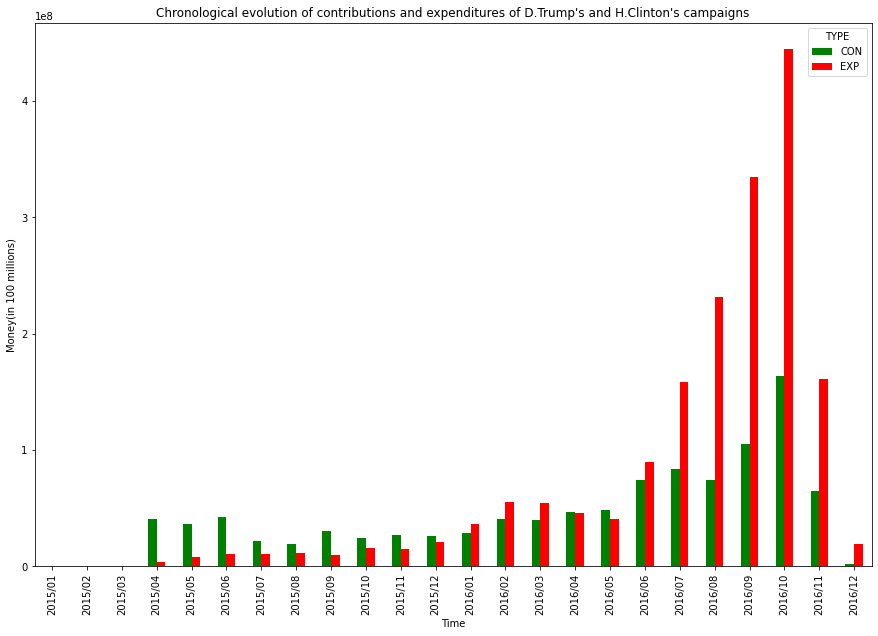

In [79]:
g_both = graph.plot(xlabel='Time', 
                    ylabel='Money(in 100 millions)',
                    title="Chronological evolution of contributions and expenditures of D.Trump's and H.Clinton's campaigns",
                    kind='bar', 
                    color=('green', 'red'), 
                    figsize=(15, 10))

* The **chronological evolution of the contributions made to and the expenditures made by D.Trump's campaign** is shown in the gragh below. 
* Contributions _(TYPE:CON)_ are in green, while expenditures _(TYPE:EXP)_ are in red. `C00580100` is the ID of D.Trump's campaign.
* Analyzing this graph, it appears to be a rise of the amounts of money raised and spent dy the campaign until November, that is when the elections occured (November, 8th).

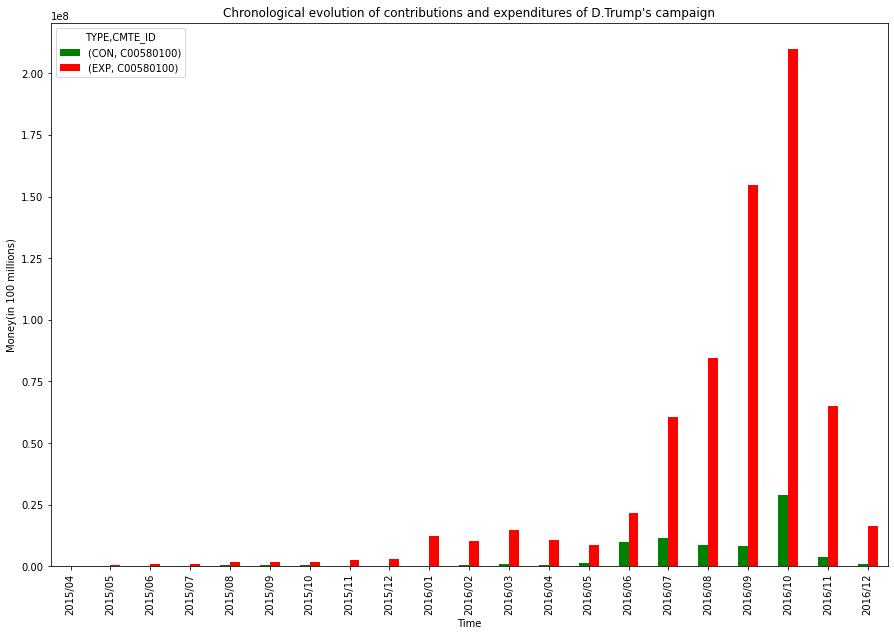

In [80]:
g_trump = graph_trump.plot(xlabel='Time', 
                           ylabel='Money(in 100 millions)',
                           title="Chronological evolution of contributions and expenditures of D.Trump's campaign",
                           kind='bar', 
                           color=('green', 'red'), 
                           figsize=(15, 10))

* The **chronological evolution of the contributions made to and the expenditures made by H.Clinton's campaign** is shown in the gragh below. 
* Contributions _(TYPE:CON)_ are in green, while expenditures _(TYPE:EXP)_ are in red. `C00575795` is the ID of H.Clinton's campaign.
* Analyzing this graph, it appears to be a rise of the amounts of money raised and spent dy the campaign until November, that is when the elections occured (November, 8th).
* In addition, it seems that H.Clinton's campaign raised more money of the contributions in comparison to D.Trump's graph.

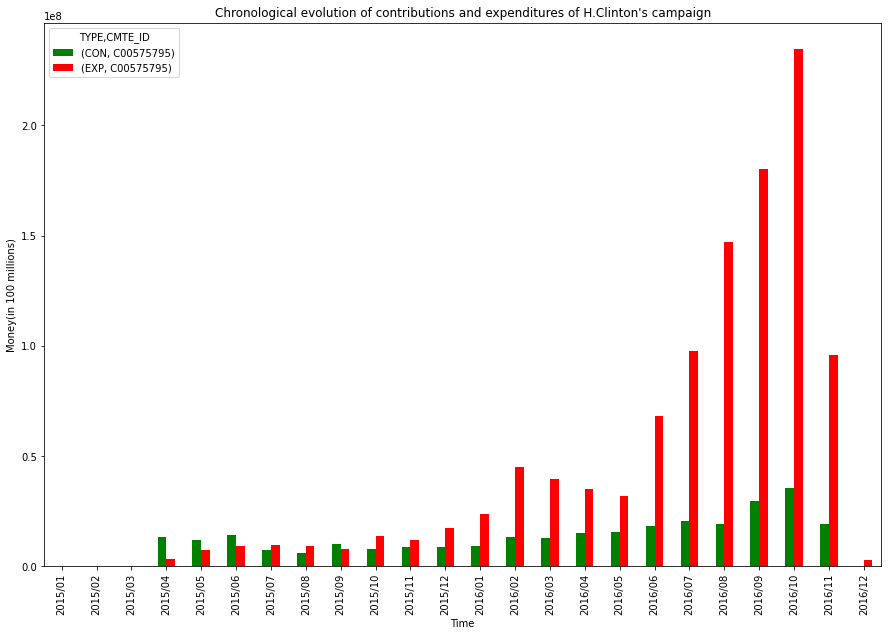

In [81]:
g_hillary = graph_hillary.plot(xlabel='Time', 
                               ylabel='Money(in 100 millions)',
                               title="Chronological evolution of contributions and expenditures of H.Clinton's campaign",
                               kind='bar', 
                               color=('green', 'red'), 
                               figsize=(15, 10))

## Exercise 4
* To find the biggest recipients of the two campaigns' expenditures, `total_ex_receiver` and `ex_maker` DataFrames will be used (defined in Exercise 3).
* The recipients will be identified by Name and State.<br>
<br>
* As a reminder, `total_ex_receiver` DataFrame contains all expenditures made to the two campaigns, while `ex_maker` DataFrame contains all expenditures made by the two campaigns.

* The ID of the recipient in `total_ex_receiver` is found at `OTHER_ID` column, while in `ex_maker` it's found at `CMTE_ID` column, so we create two DataFrames with all the needed data in columns with the same names.
* `maker_fx` DataFrame contains all expenditures made by the campaigns.
* `receiver_fx` DataFrame contains all expenditures made to the campaigns.<br>
<br>
* `REC_ID` column represents the ID of the recipient (in case of an individual it's Null)
* `REC_NAME` column represents the name of the recipient
* `CAMPAIGN` column represents the ID of D.Trump's or H.Clinton's campaign 

In [82]:
maker_fx = ex_maker[['OTHER_ID','TRANSACTION_AMT','CMTE_ID']]\
           .rename(columns={'CMTE_ID':'REC_ID',
                            'OTHER_ID':'CAMPAIGN'}, inplace = False)

receiver_fx = total_ex_receiver[['CMTE_ID','TRANSACTION_AMT','OTHER_ID','NAME']]\
              .rename(columns={'CMTE_ID':'CAMPAIGN',
                               'NAME':'REC_NAME',
                               'OTHER_ID':'REC_ID'}, inplace = False)

print(maker_fx.columns,'\n',receiver_fx.columns)

Index(['CAMPAIGN', 'TRANSACTION_AMT', 'REC_ID'], dtype='object') 
 Index(['CAMPAIGN', 'TRANSACTION_AMT', 'REC_ID', 'REC_NAME'], dtype='object')


* `maker_fx` doesn't initially have `REC_NAME` column, because an inner join with `committees` DataFrame is needed to have access to this information.

In [83]:
# add REC_NAME on maker_fx
maker_fx = pd.merge(maker_fx,
                     committees[['CMTE_NM','CMTE_ID']],
                     left_on='REC_ID',
                     right_on='CMTE_ID',
                     how='inner')

maker_fx.columns

Index(['CAMPAIGN', 'TRANSACTION_AMT', 'REC_ID', 'CMTE_NM', 'CMTE_ID'], dtype='object')

* `CMTE_ID` column added after the join is unnecessary so it is dropped from the DataFrame.
* `CMTE_NM` contains the names of the recipients, so it is renamed as `REC_NAME`

In [84]:
# drop column CMTE_ID
maker_fx = maker_fx.drop('CMTE_ID',axis=1)

# rename CMTE_NM to REC_NAME
maker_fx = maker_fx.rename(columns={'CMTE_NM':'REC_NAME'}, inplace = False)

maker_fx.sample(5)

,CAMPAIGN,TRANSACTION_AMT,REC_ID,REC_NAME
203,C00575795,1000.0,C00312777,COZEN O'CONNOR POLITICAL ACTION COMMITTEE
195,C00575795,2000.0,C00349506,FRIENDS OF MARIA
964,C00575795,1747.0,C00461251,MAC PAC
505,C00575795,5.0,C00450098,WOMENCOUNT PAC
709,C00575795,1556.0,C00577080,CALONE FOR CONGRESS


* Now that we have `maker_fx` and `receiver_fx` having same columns (by name and meaning), we can combine them into one DataFrame.

In [85]:
top_recipients = maker_fx.append(receiver_fx,ignore_index=True)
print(top_recipients.shape)
top_recipients.sample(5)

(1128830, 4)


,CAMPAIGN,TRANSACTION_AMT,REC_ID,REC_NAME
16022,C00575795,10.0,NaN,"LEWIS, JESSIE"
882198,C00580100,20.0,NaN,"BROCKMEIER, ROBERT S MR. JR."
570850,C00575795,250.0,NaN,"FUSCO, JOHN"
877256,C00580100,40.0,NaN,"COCHRAN, BENJAMIN R MR."
333442,C00575795,65.0,NaN,"ALLISON, AMY"


* The **biggest recipients of both of the two camapigns** are shown below (20 are shown, can be adjust to any number). 

In [86]:
top_recipients.groupby(['REC_ID','REC_NAME'])\
              .sum('TRANSACTION_AMT')\
              .sort_values(by='TRANSACTION_AMT',ascending=False)\
              .head(20)

,,TRANSACTION_AMT
REC_ID,REC_NAME,
C00586537,HILLARY VICTORY FUND,316400000.0
C00618371,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,242487889.0
C00618389,TRUMP VICTORY,26942704.0
C00586537,HILLARY VICTORY FUND - UNITEMIZED,19001530.0
C00619411,HILLARY ACTION FUND,5120000.0
C00008227,ARIZONA REPUBLICAN PARTY,360350.0
C00034033,SOUTH CAROLINA REPUBLICAN PARTY,45000.0
C00002089,COMMUNICATIONS WORKERS OF AMERICA-COPE POLITICAL CONTRIBUTIONS COMMITTEE,44816.0
C00084954,REPUBLICAN PARTY OF ARKANSAS,25000.0


* The **biggest recipients of D.Trump's camapign** are shown below (20 are shown, can be adjust to any number).

In [87]:
top_recipients[top_recipients['CAMPAIGN']==trump_c[0]].groupby(['REC_ID','REC_NAME'])\
                                                      .sum('TRANSACTION_AMT')\
                                                      .sort_values(by='TRANSACTION_AMT',ascending=False)\
                                                      .head(20)

,,TRANSACTION_AMT
REC_ID,REC_NAME,
C00618371,TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE,242487889.0
C00618389,TRUMP VICTORY,26942704.0
C00008227,ARIZONA REPUBLICAN PARTY,360350.0
C00034033,SOUTH CAROLINA REPUBLICAN PARTY,45000.0
C00084954,REPUBLICAN PARTY OF ARKANSAS,25000.0
C00004606,KANSAS REPUBLICAN PARTY,19470.0
C00202861,THE SENATE VICTORY FUND PAC,17700.0
C00014498,REPUBLICAN PARTY OF IOWA,16500.0
C00156810,REPUBLICAN PARTY OF KENTUCKY,15000.0


* The **biggest recipients of H.Clinton's camapign** are shown below (20 are shown, can be adjust to any number).

In [88]:
top_recipients[top_recipients['CAMPAIGN']==hillary_c[0]].groupby(['REC_ID','REC_NAME'])\
                                                        .sum('TRANSACTION_AMT')\
                                                        .sort_values(by='TRANSACTION_AMT',ascending=False)\
                                                        .head(20)

TRANSACTION_AMT
REC_ID    REC_NAME                                                           
C00586537 HILLARY VICTORY FUND                                    316400000.0
          HILLARY VICTORY FUND - UNITEMIZED                        19001530.0
C00619411 HILLARY ACTION FUND                                       5120000.0
C00002089 COMMUNICATIONS WORKERS OF AMERICA-COPE POLITICA...          44816.0
C00197863 CABLEVISION SYSTEMS CORPORATION POLITICAL ACTIO...          15000.0
C00011262 BROTHERHOOD OF RAILROAD SIGNALMEN POLITICAL ACT...          11000.0
C00139659 JOINT ACTION COMMITTEE FOR POLITICAL AFFAIRS                10461.0
C00624171 AMERICAN MUSLIM WOMEN (AMW)                                 10400.0
C00410126 AMERICANS FOR THE ARTS ACTION FUND PAC                      10400.0
C00331694 AMERICA WORKS PAC                                           10000.0
C00065219 WINE INSTITUTE PAC                                          10000.0
C00400333 INTERDIGITAL, INC., PAC                                     10000.0
C00403592 NARRAGANSETT BAY PAC                                        10000.0
C00342048 PAC FOR A CHANGE                                            10000.0
C00409730 NEW DEMOCRAT COALITION PAC                                  10000.0
C00392738 HOLDING ONTO OREGON'S PRIORITIES                            10000.0
C00344325 POLITICAL ACTION COMMITTEE OF THE INTERNATIONAL...          10000.0
C00385534 LEGPAC                                                      10000.0
C00225342 MCGUIREWOODS LLP                                            10000.0
C00219642 ENTERPRISE HOLDINGS, INC. POLITICAL ACTION COMM...          10000.0

## Exercise 5
* This exercise is divided into two main parts, getting the geographical distribution of the two campaigns' expenditures, and getting the geographical distribution of the two campaigns' expenditures per voter. 
* For the first part, all expenditures, including operating ones, will be examined.
* For the second part, all expenditures made by people (i.e. individuals or candidates), as only those can vote.   

* The DataFrames that will be used are :
    * `total_ex_receiver`, which was defined in Exercise 3 and contains all operating expeditures and expenditures made to the two campaigns. It will be used only for the first part.`
    * `ex_receiver`, which was defined in Exercise 3 and contains all expenditures made to the two campaigns, excluding the operating ones. It will be used only for the second part.
    * `ex_maker`, which was defined in Exercise 3 and contains all expenditures made by the two campaigns. It will be used only for the first part.

In [89]:
print('TOTAL_EX_RECEIVER\n',total_ex_receiver.columns,'\n\n',
      'EX_RECEIVER\n',ex_receiver.columns,'\n\n',
      'EX_MAKER\n',ex_maker.columns,'\n\n')

TOTAL_EX_RECEIVER
 Index(['CMTE_ID', 'TRANSACTION_TP', 'NAME', 'STATE', 'TRANSACTION_DT',
       'TRANSACTION_AMT', 'OTHER_ID', 'TRAN_ID', 'FILE_NUM', 'SUB_ID'],
      dtype='object') 

 EX_RECEIVER
 Index(['CMTE_ID', 'TRANSACTION_TP', 'NAME', 'STATE', 'TRANSACTION_DT',
       'TRANSACTION_AMT', 'OTHER_ID', 'TRAN_ID', 'FILE_NUM', 'SUB_ID'],
      dtype='object') 

 EX_MAKER
 Index(['CMTE_ID', 'TRANSACTION_TP', 'NAME', 'STATE', 'TRANSACTION_DT',
       'TRANSACTION_AMT', 'OTHER_ID', 'TRAN_ID', 'FILE_NUM', 'SUB_ID'],
      dtype='object') 




* `total_ex_receiver` and `ex_receiver` have same columns by name and meaning (eg.`CMTE_ID` column is the campaigns' IDs and `NAME`,`OTHER_ID`,`STATE` are information of the recipient for both DataFrames)
* `ex_maker` has the same columns as the other two DataFrames but only by name. The meaning of `CMTE_ID`,`OTHER_ID`,`NAME`,`STATE` are reverted (i.e. `CMTE_ID` column is the recipients' IDs while `NAME`,`OTHER_ID`,`STATE` are the campaigns' information).
<br><br>
* For the examination of the geographical distribution only the campaigns' IDs and each recipient's state will be needed, so all other information will be ignored.

In [90]:
# drop unneeded columns from total_ex_receiver, ex_receiver
total_ex_receiver = total_ex_receiver.drop(['TRANSACTION_TP','NAME','TRANSACTION_DT',
                                            'OTHER_ID','TRAN_ID','FILE_NUM','SUB_ID'],axis=1)

# drop unneeded columns from ex_receiver
ex_receiver = ex_receiver.drop(['TRANSACTION_TP', 'NAME', 'TRANSACTION_DT',
                                 'TRAN_ID', 'FILE_NUM', 'SUB_ID'],axis=1)

# drop unneeded columns from ex_maker (except recipients' IDs (CMTE_ID))
ex_maker = ex_maker.drop(['TRANSACTION_TP', 'NAME', 'STATE', 'TRANSACTION_DT',
       'TRAN_ID', 'FILE_NUM', 'SUB_ID'],axis=1)

print('TOTAL_EX_RECEIVER\n',total_ex_receiver.columns,'\n',total_ex_receiver.shape,'\n\n',
      'EX_RECEIVER\n',ex_receiver.columns,'\n',ex_receiver.shape,'\n\n',
      'EX_MAKER\n',ex_maker.columns,'\n',ex_maker.shape,'\n\n',)

TOTAL_EX_RECEIVER
 Index(['CMTE_ID', 'STATE', 'TRANSACTION_AMT'], dtype='object') 
 (1127831, 3) 

 EX_RECEIVER
 Index(['CMTE_ID', 'STATE', 'TRANSACTION_AMT', 'OTHER_ID'], dtype='object') 
 (955967, 4) 

 EX_MAKER
 Index(['CMTE_ID', 'TRANSACTION_AMT', 'OTHER_ID'], dtype='object') 
 (999, 3) 




* The reason we need recipients' IDs in `ex_receiver` is that it's the only way to identify whether the recipient is an individual, a candidate or another entity. Specifically, when the recipient is a person/voter, `OTHER_ID` column is either Null or has a candidate's ID.

In [91]:
# recipients who are not persons
notVoters = pd.merge(committees,
                     ex_receiver,
                     left_on='CMTE_ID',
                     right_on='OTHER_ID',
                     how='inner')

# keep only persons
ex_receiver = ex_receiver[~ex_receiver['OTHER_ID'].isin(notVoters['OTHER_ID'])]

* The reason why we need recipients' IDs in `ex_maker` is that it's the only connection we have to find all recipients' states. To do that, we execute an inner join with the `committees` DataFrame (defined in Exercise 1 and contains all committee information)

In [92]:
ex_maker = pd.merge(ex_maker,
             committees[['CMTE_ID','CMTE_ST']],
             on='CMTE_ID',
             how='inner')
ex_maker.sample(5)

,CMTE_ID,TRANSACTION_AMT,OTHER_ID,CMTE_ST
303,C00252940,56.0,C00575795,DC
336,C00003111,1500.0,C00580100,ME
131,C00490904,2700.0,C00575795,PA
335,C00003111,1500.0,C00580100,ME
389,C00586537,4500000.0,C00575795,NY


* `CMTE_ID` of the `ex_maker` DataFrame is no longer needed so it is dropped.

In [93]:
ex_maker = ex_maker.drop('CMTE_ID', axis=1)
ex_maker.columns

Index(['TRANSACTION_AMT', 'OTHER_ID', 'CMTE_ST'], dtype='object')

* To make things easier, columns `OTHER_ID` and `CMTE_ST` will be renamed so as to match with the columns' names of the other two DataFrames.

In [94]:
ex_maker = ex_maker.rename(columns={'OTHER_ID':'CMTE_ID',
                      'CMTE_ST':'STATE'}, inplace=False)

* As for the first part of the exercise, only `total_ex_receiver` and `ex_maker` DataFrames are needed.
* As for the second part, only `ex_receiver` DataFrame is needed.
* For each of the parts, we combine the data into one DataFrame.

In [95]:
part_1 = total_ex_receiver.append(ex_maker,ignore_index=True)

part_2 = ex_receiver

print(part_1.shape,'\n',part_2.shape)

(1128830, 3) 
 (955691, 4)


* The entries in column `STATE` are abbreviations of the states, plus abbreviations of US territories. So isolate the states and have full names of the states we use a [table](https://www.downloadexcelfiles.com/sites/default/files/docs/list-states-us-36j.csv) which has the 50 states with their full names and their abbreviations.

In [96]:
states = pd.read_csv('https://www.downloadexcelfiles.com/sites/default/files/docs/list-states-us-36j.csv',
                      sep=",",
                      index_col=1,
                      skiprows=[2,53,54],
                      usecols=[1,2],
                      header=1)
states

,State
Abbr.,
AL,Alabama
AK,Alaska
AZ,Arizona
AR,Arkansas
CA,California
CO,Colorado
CT,Connecticut
DE,Delaware
FL,Florida


* To add to our data the full names of the states and to isolate the states from the territories, we execute an inner join.

In [97]:
part_1 = pd.merge(part_1,
             states,
             left_on='STATE',
             right_on='Abbr.',
             how='inner')

part_2 = pd.merge(part_2,
             states,
             left_on='STATE',
             right_on='Abbr.',
             how='inner')

print(part_1['STATE'].unique(),'\n\n',
      part_2['STATE'].unique())

['PA' 'NY' 'IL' 'CA' 'VA' 'NJ' 'IA' 'OR' 'TX' 'MN' 'CT' 'MD' 'FL' 'WA'
 'CO' 'MA' 'NV' 'KY' 'SD' 'GA' 'AZ' 'NC' 'TN' 'AL' 'KS' 'WV' 'MI' 'OH'
 'WI' 'NH' 'UT' 'OK' 'WY' 'NM' 'SC' 'DE' 'IN' 'MS' 'ME' 'MO' 'HI' 'NE'
 'RI' 'LA' 'AR' 'VT' 'MT' 'AK' 'ID' 'ND'] 

 ['NY' 'IL' 'CA' 'VA' 'NJ' 'IA' 'OR' 'TX' 'MN' 'CT' 'MD' 'FL' 'WA' 'CO'
 'MA' 'NV' 'KY' 'SD' 'GA' 'AZ' 'NC' 'TN' 'AL' 'KS' 'WV' 'MI' 'OH' 'WI'
 'NH' 'UT' 'PA' 'OK' 'WY' 'NM' 'SC' 'DE' 'IN' 'MS' 'ME' 'MO' 'HI' 'NE'
 'RI' 'LA' 'AR' 'VT' 'MT' 'AK' 'ID' 'ND']


* To find the expenditures per state, we need to have only one entry per state.
* `total` DataFrame contains all expenditures of the two campaigns per state, while `trump_hillary` contains all expenditures per state of each campaign separately.
* Later, these DataFrames will be used to create bar-graphs using Pandas's [plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) method method

In [98]:
part_1 = part_1.rename(columns={'TRANSACTION_AMT':'Expenditures'},inplace=False)

total = part_1.pivot_table(index='State',
                           values='Expenditures',
                           aggfunc='sum')

trump_hillary = part_1.pivot_table(index='State',
                                   columns=['CMTE_ID'],
                                   values='Expenditures',
                                   aggfunc='sum')

* **The geographical distribution, at a state level, of both of the two camapigns' expenditures** is shown below.

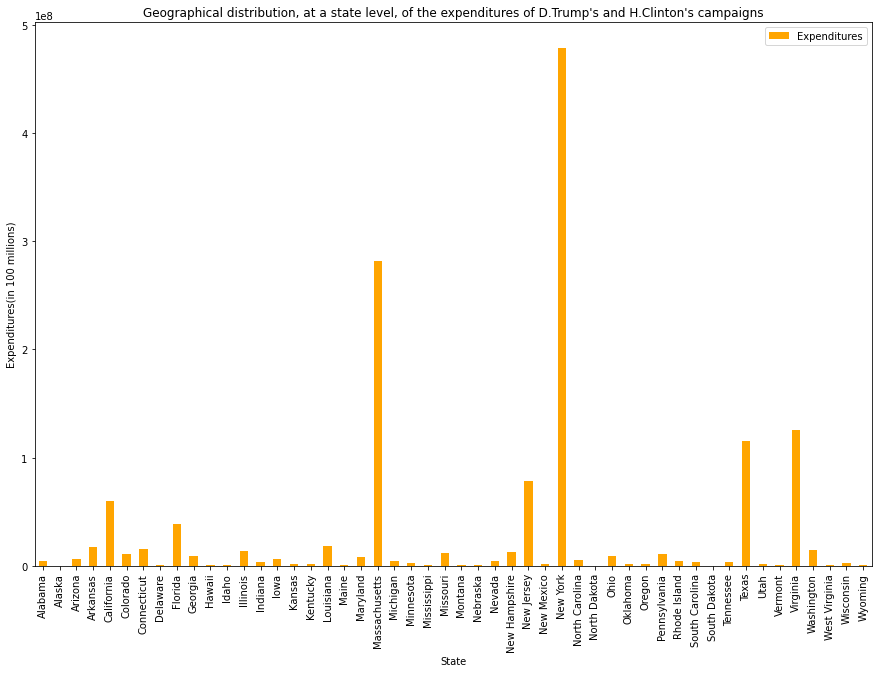

In [99]:
g_both = total.plot(xlabel='State', 
                    ylabel='Expenditures(in 100 millions)',
                    title="Geographical distribution, at a state level, of the expenditures of D.Trump's and H.Clinton's campaigns",
                    kind='bar', 
                    color=('orange'), 
                    figsize=(15, 10))

* **The geographical distribution, at a state level, of D.Trump's and H.Clinton's campaigns' expenditures separately** is shown below.

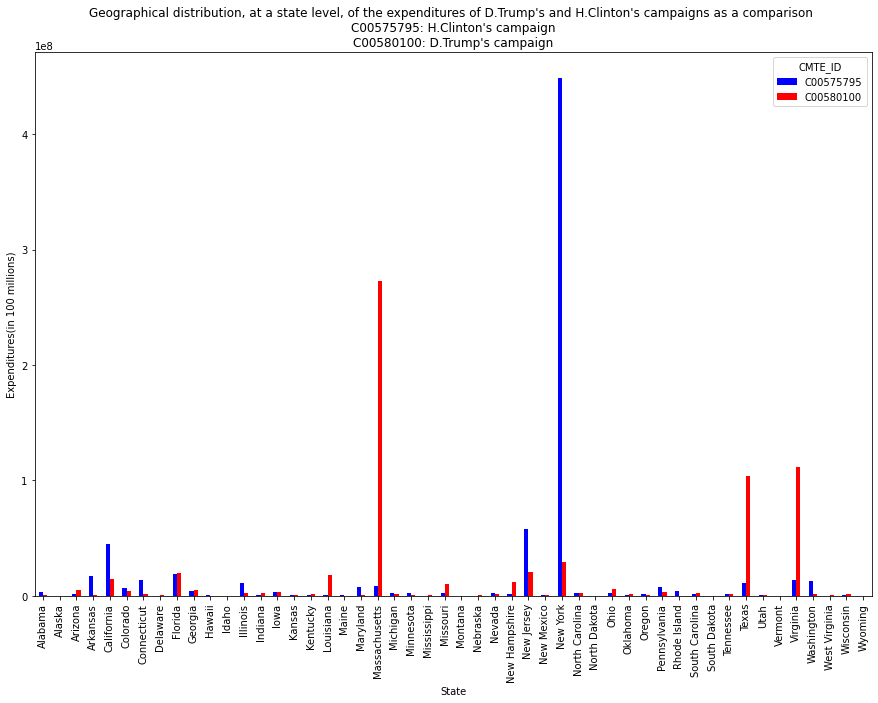

In [100]:
comparison = trump_hillary.plot(xlabel='State', 
                                ylabel='Expenditures(in 100 millions)',
                                title="Geographical distribution, at a state level, of the expenditures of D.Trump's and H.Clinton's campaigns as a comparison \nC00575795: H.Clinton's campaign\nC00580100: D.Trump's campaign",
                                kind='bar', 
                                color=('blue','red'), 
                                figsize=(15, 10))

* To find the expenditures per voter per state, we need to know the number of registered voters by state. This information can be found at https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx 
* As the information is stored in a xlsx file, Pandas' [read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) will be used to convert the data into a DataFrame.
* The numbers stored in the xlsx file are in thousands, so it's neccessary to multiply them by 1000.
* Moreover, to match the entries of `State` column with `part_2`'s entries of the same column, we capitalize each word's 1st letter using Pandas' s [str.title](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.title.html)

In [101]:
voters = pd.read_excel('https://www2.census.gov/programs-surveys/cps/tables/p20/580/table04a.xlsx',
                     index_col=False,
                     names=['State','VotersNum'],
                     usecols=[0,8],
                     skiprows=[0,1,2,3,4,57,58,59,60,61,62,63],
                     dtype={'State':np.str,'VotersNum':np.int})

# multiply all entries of 'VotersNum' by 1000
voters['VotersNum'] *= 1000

# capitalize each word's 1st letter in entries of 'State'
voters['State'] = (voters['State']).str.title()

voters.sample(5)

,State,VotersNum
30,New Jersey,3665000
17,Kentucky,1850000
47,Washington,3382000
29,New Hampshire,698000
22,Michigan,4713000


* To find expenditures per voter we have to make the division expendituresPerState/VotersNum and store the result in a new column.
* First, we must find all expenditures by state
    * `exPerState` DataFrame contains all expenditures by state for both campaigns 
    * `exPerStateCam` DataFrame contains all expenditures by state for each campaign separately

In [102]:
exPerState = (part_2.groupby(['State']).sum('TRANSACTION_AMT')).reset_index()
exPerStateCom = (part_2.groupby(['State','CMTE_ID']).sum('TRANSACTION_AMT')).reset_index()

exPerState = exPerState.rename(columns={'TRANSACTION_AMT':'Expenditures/State'})
exPerStateCom =  exPerStateCom.rename(columns={'TRANSACTION_AMT':'Expenditures/State'})

display(exPerState.head(3))
display(exPerStateCom.head(6))

,State,Expenditures/State
0,Alabama,1341836.0
1,Alaska,280965.0
2,Arizona,2525522.0


,State,CMTE_ID,Expenditures/State
0,Alabama,C00575795,646833.0
1,Alabama,C00580100,695003.0
2,Alaska,C00575795,177171.0
3,Alaska,C00580100,103794.0
4,Arizona,C00575795,1276068.0
5,Arizona,C00580100,1249454.0


* Then, we need to execute an inner join of `exPerState` with `voters`, to combine the data we have collected and calculate the expenditures per voter by state.
* Same goes for the `exPerStateCom`.

In [103]:
exvoter_st = pd.merge(exPerState,
                       voters,
                       on='State',
                       how='inner')
exvoter_stcom = pd.merge(exPerStateCom,
                         voters,
                         on='State',
                         how='inner')

# calculate expenditures/voter by state
division_st = exvoter_st['Expenditures/State']/exvoter_st['VotersNum']
# calculate expenditures/voter by state for each campaign separetely
division_com = exvoter_stcom['Expenditures/State']/exvoter_stcom['VotersNum']

# insert data in right DataFrame
exvoter_st.insert(3,'Expenditures/Voter',division_st,allow_duplicates=True)
exvoter_stcom.insert(3,'Expenditures/Voter',division_com,allow_duplicates=True)

# VotersNum and Expenditures/State are no longer needed
exvoter_st = exvoter_st.drop(['Expenditures/State','VotersNum'],axis=1)

display(exvoter_st.head(3))
exvoter_stcom.head(6)

,State,Expenditures/Voter
0,Alabama,0.640495
1,Alaska,0.912224
2,Arizona,0.912070


,State,CMTE_ID,Expenditures/State,Expenditures/Voter,VotersNum
0,Alabama,C00575795,646833.0,0.308751,2095000
1,Alabama,C00580100,695003.0,0.331744,2095000
2,Alaska,C00575795,177171.0,0.575231,308000
3,Alaska,C00580100,103794.0,0.336994,308000
4,Arizona,C00575795,1276068.0,0.460841,2769000
5,Arizona,C00580100,1249454.0,0.451229,2769000


* To have each campaign's data we need to merge `exvoter_stcom` with the data we stored in `part_2`(which contains the data).
* The new DataFrame `trump_hillary` is then converted into a pivot table to be used later for graph

In [104]:
# rename column
part_2 = part_2.rename(columns={'TRANSACTION_AMT':'Expenditures'},inplace=False)

# merge the data
trump_hillary = pd.merge(part_2,
                         exvoter_stcom,
                         on=['State','CMTE_ID'],
                         how='inner')

# create pivot to later create graph
trump_hillary = trump_hillary.pivot_table(index='State',
                                          columns=['CMTE_ID'],
                                          values='Expenditures',
                                          aggfunc='sum')

* **The geographical distribution, at a state level, of both of D.Trump's and H.Clinton's campaigns' expenditures per voter** is shown below.

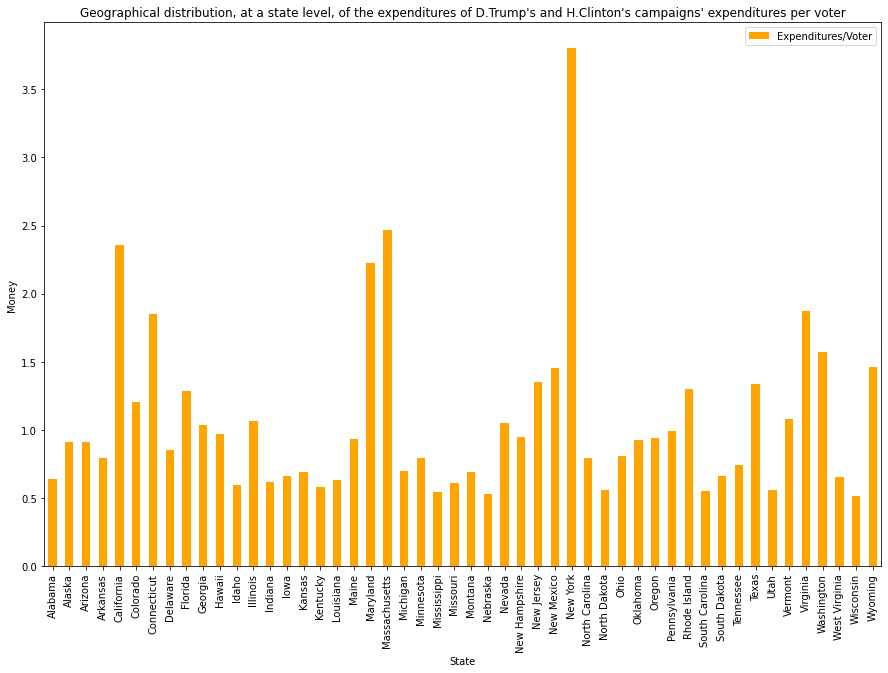

In [105]:
g_both = exvoter_st.set_index('State')\
                   .plot(xlabel='State', 
                         ylabel='Money',
                         title="Geographical distribution, at a state level, of the expenditures of D.Trump's and H.Clinton's campaigns' expenditures per voter",
                         kind='bar', 
                         color=('orange'), 
                         figsize=(15, 10))

* **The geographical distribution, at a state level, of D.Trump's campaign's expenditures per voter** is shown below.

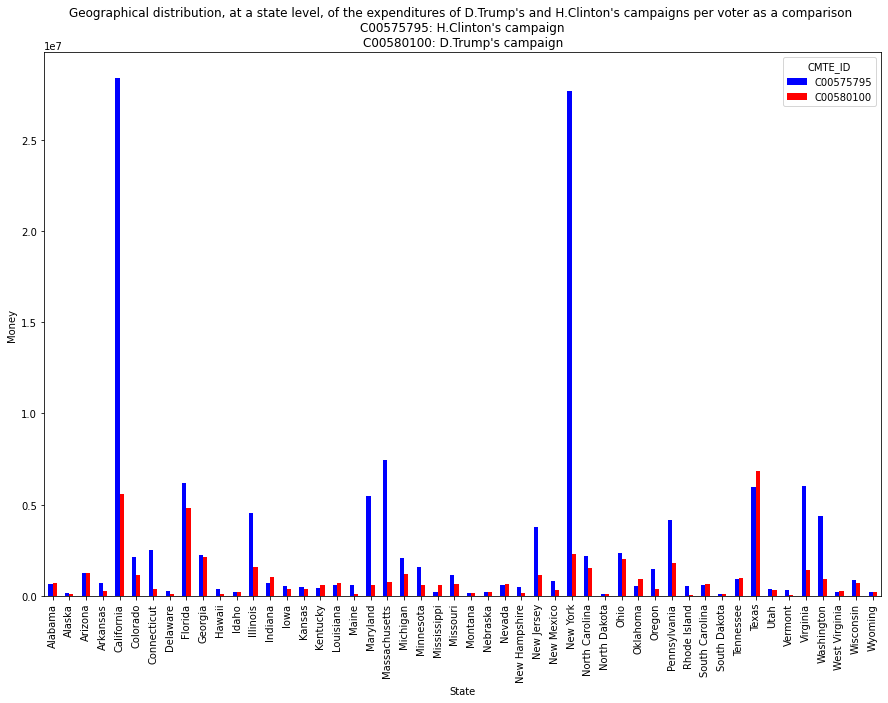

In [106]:
comparison = trump_hillary.plot(xlabel='State', 
                         ylabel='Money',
                         title="Geographical distribution, at a state level, of the expenditures of D.Trump's and H.Clinton's campaigns per voter as a comparison \nC00575795: H.Clinton's campaign\nC00580100: D.Trump's campaign",
                         kind='bar', 
                         color=('blue','red'), 
                         figsize=(15, 10))

* According to [en.wikipedia.org](https://en.wikipedia.org/wiki/Swing_state#:~:text=Swing%20states%20and%20tipping%20point%20states%2C%202000%E2%80%932016%20,%20New%20Hampshire%20%208%20more%20rows%20), the swing states are Wisconsin, Pennsylvania, New Hampshire, Minnesota, Arizona, Georgia, Florida, Michigan, Nevada, North Carolina, and Maine. 

In [107]:
swing_st = ['Wisconsin','Pennsylvania','New Hampshire','Minnesota','Arizona','Georgia','Florida',
            'Michigan','Nevada','North Carolina','Maine']

* The **geographical distribution on all swing states of both of D.Trump's and H.Clinton's campaigns' expenditures per voter** are shown below.

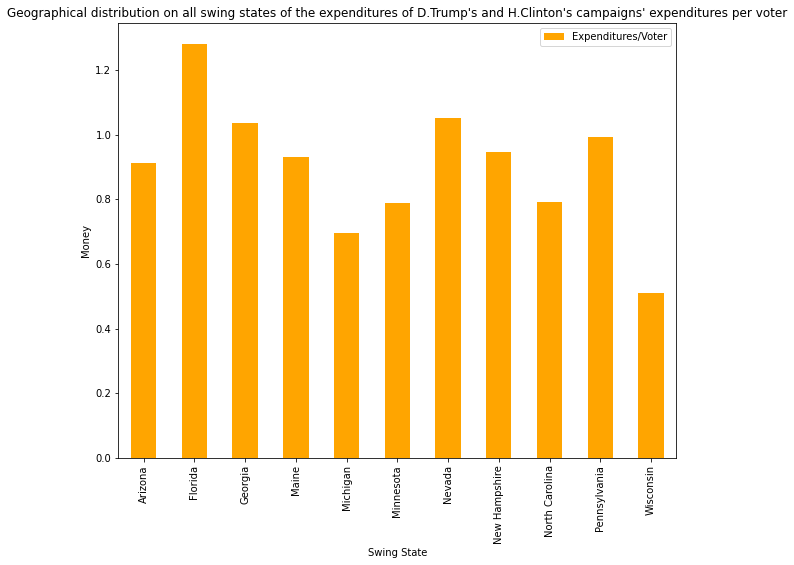

In [108]:
total_swing = exvoter_st[exvoter_st['State'].isin(swing_st)]\
                                            .set_index('State')\
                                            .plot(xlabel='Swing State', 
                                                  ylabel='Money',
                                                  title="Geographical distribution on all swing states of the expenditures of D.Trump's and H.Clinton's campaigns' expenditures per voter",
                                                  kind='bar', 
                                                  color=('orange'), 
                                                  figsize=(10, 8))

* The **geographical distribution on all swing states of D.Trump's and H.Clinton's campaigns' expenditures per voter separately** are shown below.

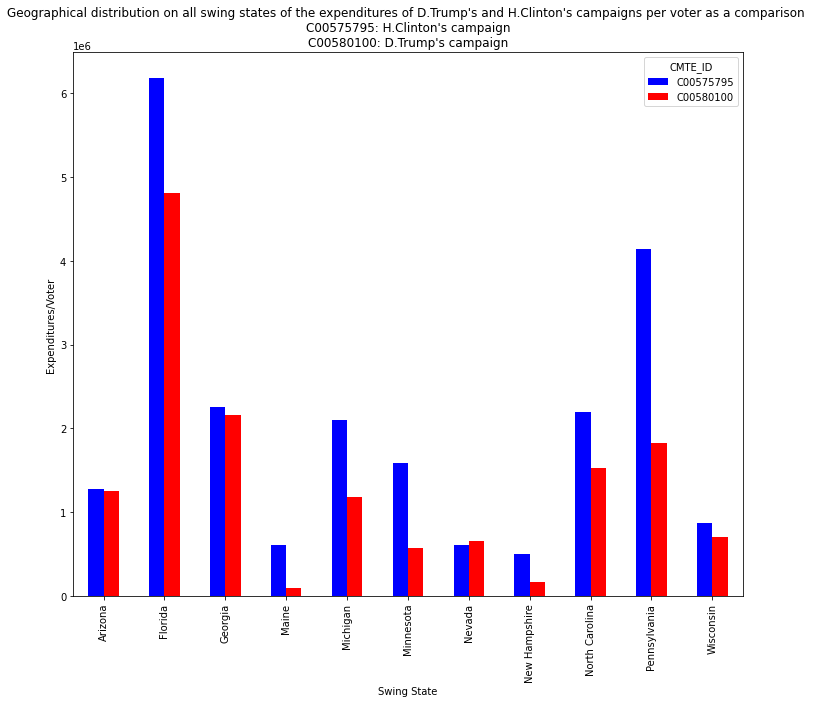

In [109]:
comparison_swing = trump_hillary[trump_hillary.index\
                                              .isin(swing_st)]\
                                              .plot(xlabel='Swing State', 
                                                    ylabel='Expenditures/Voter',
                                                    title="Geographical distribution on all swing states of the expenditures of D.Trump's and H.Clinton's campaigns per voter as a comparison \nC00575795: H.Clinton's campaign\nC00580100: D.Trump's campaign",
                                                    kind='bar', 
                                                    color=('blue','red'), 
                                                    figsize=(12, 10))

* As a comparison between swing and non swing states, the **geographical distribution on all swing and non-swing states of both of D.Trump's and H.Clinton's campaigns' expenditures per voter** is shown below.

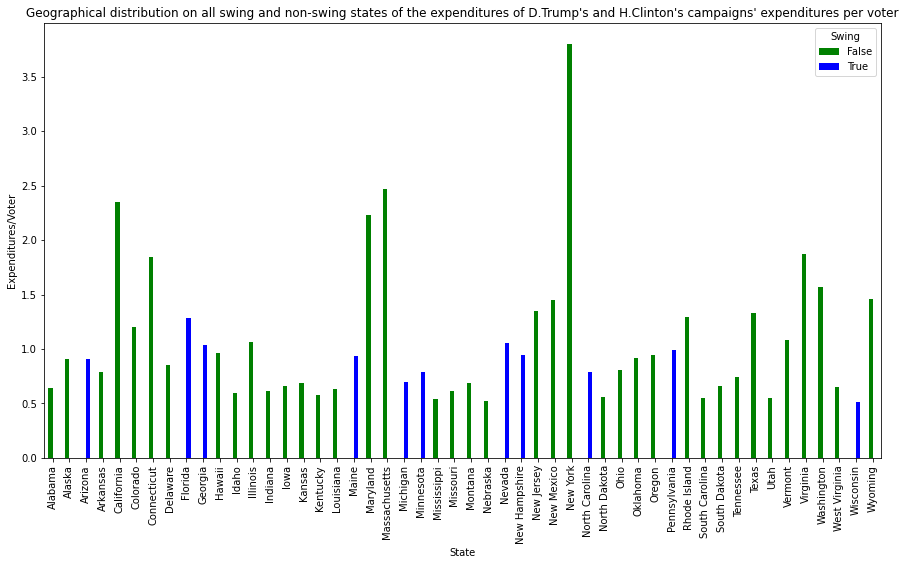

In [110]:
# insert column with boolean values of whether a state is swing or not
exvoter_st.insert(2,'Swing',None,allow_duplicates=True)
exvoter_st['Swing'] = exvoter_st['State'].isin(swing_st)

# create pivot table to use on plot
exvoter_st = exvoter_st.pivot_table(index='State',
                      columns='Swing',
                      values='Expenditures/Voter',
                      aggfunc='sum')

# create graph
total_swing = exvoter_st.plot(xlabel='State', 
                            ylabel='Expenditures/Voter',
                            title="Geographical distribution on all swing and non-swing states of the expenditures of D.Trump's and H.Clinton's campaigns' expenditures per voter",
                            kind='bar', 
                            color=('green','blue'), 
                            figsize=(15, 8))